In [1]:
# Install a conda package in the current Jupyter kernel
import sys

In [ ]:
!conda install --yes --prefix {sys.prefix} numpy

In [22]:
import numpy as np

class softmax_layer:
    def dim_in(self):
        return 0
    
    def dim_out(self):
        return 0
    
    def update_weigths(self, gradient, learning_rate):
        return gradient
    
    def __call__(self, x):
        #exp = np.exp(x.T - np.max(x, axis=1))
        exp = np.exp(x)
        return (exp.T / np.sum(exp, axis=1))

In [23]:
class linear_layer:
    def __init__(self, dim_in, dim_out):
        self._A = np.random.rand(dim_in,dim_out)
        self._B = np.random.rand(dim_out)
        self._dim_in = dim_in
        self._dim_out = dim_out
        
    def update_weigths(self, gradient, learning_rate):
        self._A = self._A - learning_rate * gradient
        return gradient
    
    def dim_in(self):
        return self._dim_in
    
    def dim_out(self):
        return self._dim_out
    
    def __call__(self, x):
        return x.T.dot(self._A) + self._B

In [24]:
def cross_entropy_loss(y_true, y_predicted, epsilon=1e-10):
    predictions = np.clip(y_predicted, epsilon, 1. - epsilon)
    M = predictions.shape[1]
    return -np.sum(y_true * np.log(predictions)) / M

In [25]:
class sequential_model:
    def __init__(self, *layers, learning_rate=0.1):
        self._learning_rate = learning_rate
        self._layers = []
        last_dim_out = 0
        for layer in layers:
            if last_dim_out != 0 and layer.dim_in() != 0 and last_dim_out != layer.dim_in():
                print('dimension dont match layer out dim {} , next layer dim in {}'.format(last_dim_out, layer.dim_in()))
                raise 
            self._layers.append(layer)
            if layer.dim_out() != 0:
                last_dim_out = layer.dim_out()
                
    def update_weigths(self, gradient):
        for layer in reversed(self._layers):
            gradient = layer.update_weigths(gradient, self._learning_rate)
            
    def __call__(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

In [59]:
model = sequential_model(
        linear_layer(2, 5),
        softmax_layer()
        )

In [60]:
!conda install --yes --prefix {sys.prefix} scipy

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda




In [61]:
import scipy.io
mat = scipy.io.loadmat('PeaksData.mat')

In [62]:
X = mat['Yt']
Y = mat['Ct']
print(X.shape)

(2, 25000)


In [63]:
Y_predicted = model(X)
print(Y.shape)
print(Y_predicted.shape)
print(Y_predicted.T)

(5, 25000)
(5, 25000)
[[0.08504091 0.29248734 0.07763734 0.24029661 0.3045378 ]
 [0.10956353 0.25837147 0.10096388 0.25430699 0.27679414]
 [0.09325683 0.25880204 0.06470095 0.19677264 0.38646755]
 ...
 [0.33878784 0.07633619 0.25473658 0.19541057 0.13472882]
 [0.3564569  0.07457265 0.22968711 0.17887212 0.16041122]
 [0.33281815 0.08300564 0.23201192 0.19308644 0.15907785]]


In [64]:
print(cross_entropy_loss(Y, Y_predicted))

1.9246168286286058


In [65]:
def softmax_gradient(X, Y_true, Y_predicted):
    M = X.shape[1]
    grad = Y_predicted - Y_true
    return 1/M * X.dot((Y_predicted - Y_true).T)

In [66]:
def accuracy(Y_true, Y_predicted):
    return np.sum(np.argmax(Y_true, axis=0) == np.argmax(Y_predicted, axis=0)) / Y_true.shape[1]

In [67]:
print(softmax_gradient(X, Y, Y_predicted))
print(accuracy(Y, Y_predicted))

def SGD(model, X, Y, epoch):
    loss = []
    accuracy_sgd = []
    for i in range(epoch):
        Y_predicted = model(X)
        gradient = softmax_gradient(X, Y, Y_predicted)
        model.update_weigths(gradient)
        accuracy_sgd.append(accuracy(Y, Y_predicted))
        loss.append(cross_entropy_loss(Y, Y_predicted))
    return loss, accuracy_sgd

[[-0.10086099  0.15673442  0.02754784 -0.011042   -0.07237927]
 [ 0.5066956   0.04248063  0.11719928 -0.18934192 -0.47703359]]
0.12052


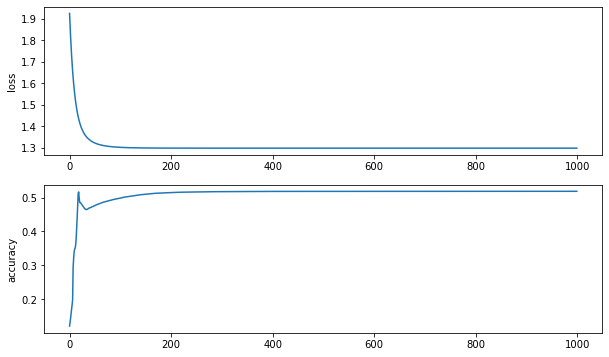

In [68]:
import matplotlib.pyplot as plt

model_loss, model_accuracy = SGD(model, X, Y, 1000)

#fig = plt.figure(figsize=(10,6))

fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(model_loss)
axs[0].set_ylabel('loss')

axs[1].plot(model_accuracy)
axs[1].set_ylabel('accuracy')

plt.show()